## Load Pubmed Abstract Download

There are four types of open download format supported by Pubmed: 
- Summary (text): an unstructued text file with summary information (everything except for abstract) of the search result
- **Pubmed: a semi-structured text file with all information of the search result**
- PMID: a text file with a list of PMID of the search results
- Abstract (text): an human-readable but unstructured test file with abstracts of the search result
- **CSV: a well-structured csv file with summary information (verything except for abstract) of the search result**

We downloaded the **Pubmed** and **CSV** formats for easier parsing, which are saved under `../data` as: 
- `als-mnd-risk-factor-ab.txt`
- `als-mnd-risk-factor-meta.csv`

After running the `tokenize_abstract.py` script, a json file with PMID and tokenized vector of title and abstract of the literature is created under `../data` as:
- `als-mnd-risk-factor-ab.json`

This script assumes the pre-processed json file has been created. 

In [153]:
# import library
import os
import json
import pandas as pd
from nltk import FreqDist
import matplotlib.pyplot as plt
from adjustText import adjust_text
from math import log

In [95]:
# load json file
# fn = 'als-mnd-risk-factor-ab-sample'
fn =  'als-mnd-risk-factor-ab'
fn_dir = f'{os.path.dirname(os.getcwd())}\\data'
with open(f'{fn_dir}\\{fn}.json','r') as json_file:
    ab = json.load(json_file)

# load other metadata with PMID for linkage
meta = pd.read_csv(f'{fn_dir}\\als-mnd-risk-factor-meta.csv',
                   usecols= ['PMID','Publication Year'],index_col=0)

## Proximity search
As a quick and dirty approach, we want to look for word frequencies within the proximity of words like 'risk', 'factor', 'cause' and their synonyms. Let w be the size of the contextual/embedding window, we will collect frequency distribution of unigrams over literature years. Meanwhile, we will also perform relevance filtering to remove any articles without the keyword "amyotrophic lateral sclerosis" or "als". 

In [121]:
def word_dist_over_year(fw:list,kw:list,rw:list,yr_key:list,w:int,top_k:int):
    yr_words = dict.fromkeys(yr_key,[])
    yr_docs = dict.fromkeys(yr_key,0)  
    for k, v in ab.items():
        # pre-screening
        incld_fw = [i for i in range(len(v)) if v[i] in fw]
        incld_kw = [i for i in range(len(v)) if v[i] in kw]
        if not incld_fw or not incld_kw:
            continue
        
        # retrieve document year
        yr = meta.loc[[int(k)]]['Publication Year'].iat[0]
        yr_docs[yr] = yr_docs[yr] + 1

        # collection of words
        word_lst =[]
        for key in kw:
            if key not in v: continue
            # get words in proximity of keyword (e.g. risk factor)
            kw_idx = v.index(key)
            search_start = max(kw_idx - w - 1, 0)
            search_end = min(kw_idx + w + 1, len(v))
            word_lst += v[search_start:search_end] 
            # filter out search words and irrelevant words
            word_lst_filter = [i for i in word_lst if i not in fw + kw + rw]
            yr_words[yr] = yr_words[yr] + word_lst_filter  

    # get word frequencies for each year
    yr_wordist = {}
    for yr, w in yr_words.items():
        if not w:
            continue
        else:
            fdist = FreqDist(w)
            fdist_sorted = {k: v for k, v in sorted(fdist.items(), key=lambda item: item[1],reverse = True)}
            yr_wordist[yr] = [yr_docs[yr],
                              list(fdist_sorted.keys())[:top_k],
                              list(fdist_sorted.values())[:top_k]
                             ]    
    # output
    return(yr_wordist)

In [176]:
risk_fac = word_dist_over_year(fw = ['als','amyotrophic','lateral','sclerosis'],
                               kw = ['risk','factor','factors','cause','causes','associated','association','potential'],
                               rw = ['disease','diseases','patient','patients','degenerative','neurodegenerative',
                                     'study','studies','may','p','wis','ci','ad','survival','includinhg','control','later',
                                     'due','identified','investigate','due','later','progression','found','result','results',
                                     'increased','probably','control','least','exist','higher','several','death','used','identify',
                                     'sals','hypothesized','onset','suggested','possibility','exists','effect','effects','review',
                                     'expansions','evidence','case','cases'],
                               yr_key = list(sorted(set(meta['Publication Year'].values.tolist()))),
                               w = 10,
                               top_k = 5
                               )

with open(f'{fn_dir}\\{fn}-proc.json','w') as fw:
    json.dump(risk_fac, fw, indent=4)

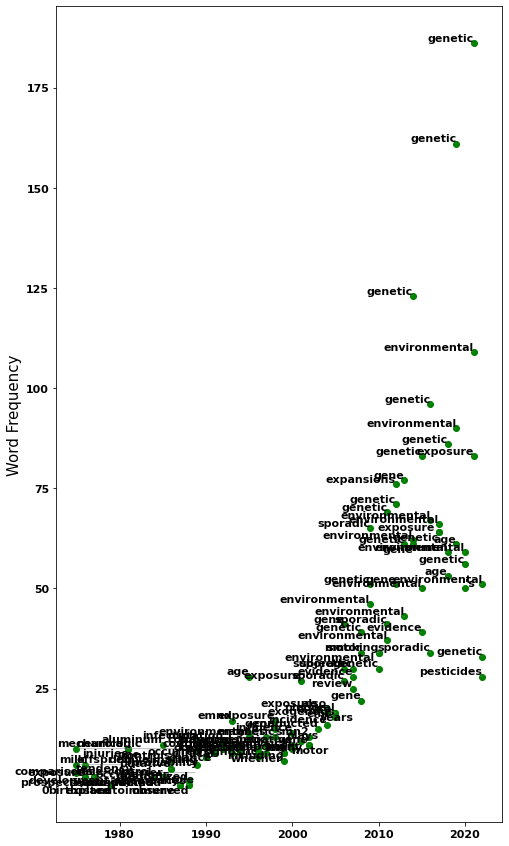

In [173]:
# simple scatter plot
fig, wordplot = plt.subplots(figsize=(8,15))
for k in risk_fac.keys():
    x_coord = [k]*len(risk_fac[k][1])
    word_freq = risk_fac[k][2]
    word_label = risk_fac[k][1]

    # raw frequency
    freq_texts = []
    for x, y, s in zip(x_coord, word_freq, word_label):
        freq_texts.append(plt.text(x, y, s))
    wordplot.plot(x_coord, word_freq, 'go')
    adjust_text(freq_texts,arrowprops=dict(arrowstyle="-", color='gray', alpha = 0.5),
                 expand_text=(1.01, 1.05), expand_points=(1.01, 1.05),
                 only_move={'points':'y', 'text':'xy', 'objects':'y'}) 

    # for pretty printout
    plt.rcParams.update({'font.size': 11})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams.update({'axes.labelsize': 10})
    plt.ylabel('Word Frequency',fontsize = 15)

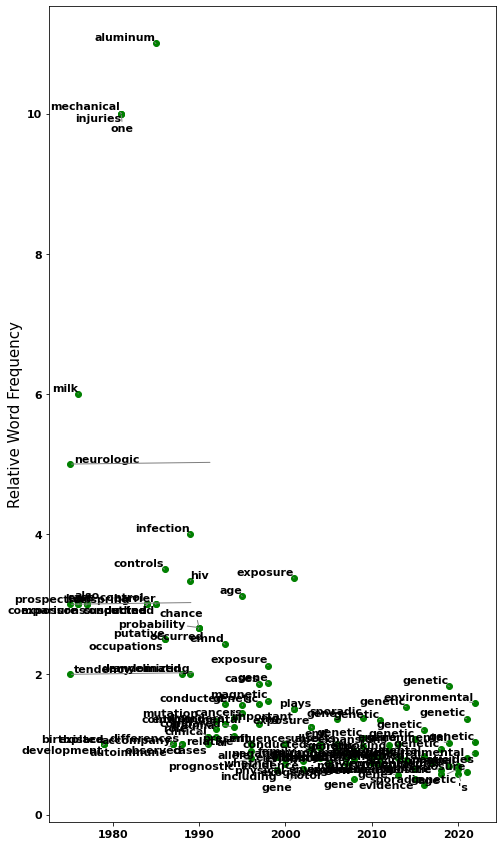

In [169]:
# simple scatter plot
fig, wordplot = plt.subplots(figsize=(8,15))
for k in risk_fac.keys():
    x_coord = [k]*len(risk_fac[k][1])
    word_freq = risk_fac[k][2]
    word_freq_rel = [f/risk_fac[k][0] for f in risk_fac[k][2]]
    word_label = risk_fac[k][1]

    # relative frequency
    freq_rel_texts = []
    for x, y, s in zip(x_coord, word_freq_rel, word_label):
        freq_rel_texts.append(plt.text(x, y, s))    
    wordplot.plot(x_coord, word_freq_rel, 'go')
    adjust_text(freq_rel_texts,arrowprops=dict(arrowstyle="-", color='grey'))

    # for pretty printout
    plt.rcParams.update({'font.size': 11})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams.update({'axes.labelsize': 9})
    plt.ylabel('Relative Word Frequency',fontsize = 15)